In [30]:
import os
from pathlib import Path

from dotenv import load_dotenv
import pandas as pd

print("Loaded .env:", load_dotenv("../../.env", override=True))
data_dir = Path(os.environ["PROJECT_DIR"]) / "data" / "host" / "diann_2023"

from prompts import prompt_t1_diann

SPLIT = "val"
LANG = "en"

Loaded .env: True


In [31]:
import json

t1 = json.load(open(data_dir / f"{SPLIT}_t1_{LANG}.json"))

tokens = t1[0]["tokens"]
labels = t1[0]["value"]

list(zip(tokens, labels))

[('Case', 'O'),
 ('report', 'O'),
 ('This', 'O'),
 ('is', 'O'),
 ('a', 'O'),
 ('19', 'O'),
 ('-', 'O'),
 ('year', 'O'),
 ('-', 'O'),
 ('old', 'O'),
 ('male', 'O'),
 ('with', 'O'),
 ('bilateral', 'O'),
 ('external', 'O'),
 ('rectus', 'O'),
 ('muscle', 'O'),
 ('palsy', 'O'),
 ('secundary', 'O'),
 ('to', 'O'),
 ('trauma', 'O'),
 ('.', 'O'),
 ('During', 'O'),
 ('treatment', 'O'),
 (',', 'O'),
 ('an', 'O'),
 ('inadvertent', 'O'),
 ('intraocular', 'O'),
 ('injection', 'O'),
 ('of', 'O'),
 ('botulinum', 'O'),
 ('toxin', 'O'),
 ('was', 'O'),
 ('present', 'O'),
 (',', 'O'),
 ('causing', 'O'),
 ('a', 'O'),
 ('retinal', 'O'),
 ('tear', 'O'),
 ('and', 'O'),
 ('localized', 'O'),
 ('retinal', 'O'),
 ('detachment', 'O'),
 ('.', 'O'),
 ('Both', 'O'),
 ('lesions', 'O'),
 ('were', 'O'),
 ('delimited', 'O'),
 ('with', 'O'),
 ('laser', 'O'),
 ('observing', 'O'),
 ('a', 'O'),
 ('spontaneous', 'O'),
 ('resolution', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('detachment', 'O'),
 ('without', 'O'),
 ('presenting', '

In [32]:
from datasets import Dataset

def format(example):

    entities = []
    temp = []
    for t, v in zip(example["tokens"], example["value"]):
        if v.startswith("B"):
            if temp:
                entities.append(" ".join(temp))
 
            temp = [t]
        elif v.startswith("I"):
            temp.append(t)

    if temp:
        entities.append(" ".join(temp))

    return {
        "text": prompt_t1_diann + " ".join(example["tokens"]),
        "response": "\n".join(entities)
    }


ds = Dataset.from_list(t1)

ds = ds.map(format, num_proc=10)

Map (num_proc=10):   0%|          | 0/98 [00:00<?, ? examples/s]

# Double-checking to make sure it works properly

In [33]:
x = ds.shuffle()[0]

values = [t for t,v in zip(x["tokens"], x["value"]) if v != "O"]
r = x["response"]

print(values)
print(r)

['sudden', 'visual', 'loss']
sudden visual loss


In [34]:
final_cols = ["text", "response"]

fds = ds.remove_columns([x for x in ds.column_names if x not in final_cols])

fds.to_parquet(data_dir / f"{SPLIT}_t1_{LANG}_formatted.parquet")

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

185593

# Check token lengths

In [35]:
from transformers import AutoTokenizer

llama = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B-Instruct")
qwen = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-1.5B-Instruct")
mistral = AutoTokenizer.from_pretrained("mistralai/Ministral-8B-Instruct-2410")

Map (num_proc=10):   0%|          | 0/98 [00:00<?, ? examples/s]

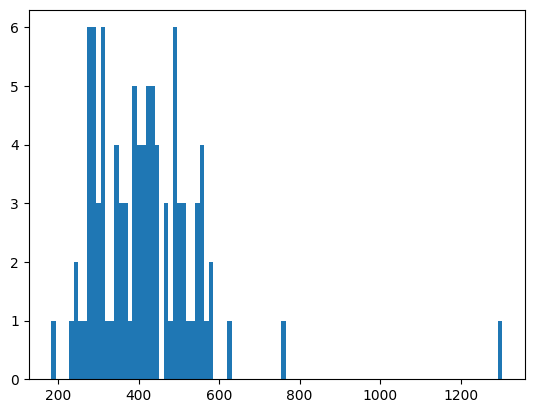

Map (num_proc=10):   0%|          | 0/98 [00:00<?, ? examples/s]

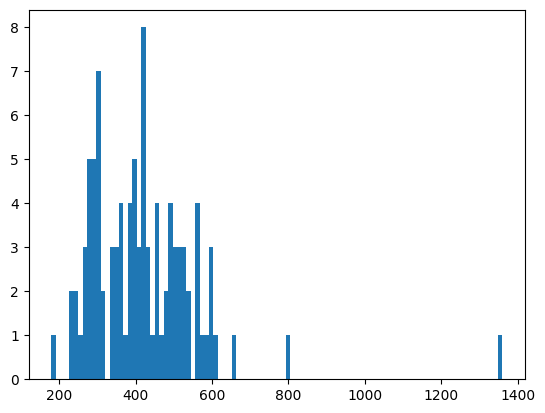

Map (num_proc=10):   0%|          | 0/98 [00:00<?, ? examples/s]

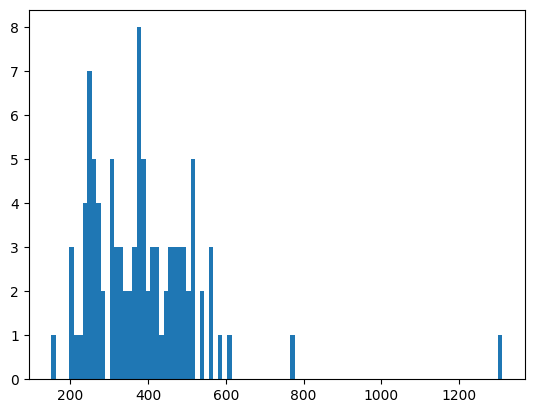

In [36]:
import matplotlib.pyplot as plt


tokenizers = [llama, qwen, mistral]

def tokenize(example, tokenizer):
    tokens = tokenizer.apply_chat_template([{"role": "user", "content": example["text"]}, {"role": "assistant", "content":example["response"]}])

    return {
        "length": len(tokens)
    }

for tokenizer in tokenizers:
    temp_ds = ds.map(tokenize, fn_kwargs={"tokenizer": tokenizer}, num_proc=10)
    plt.hist(temp_ds["length"], bins=100)
    plt.show()